In [17]:
!git clone https://github.com/opendp/smartnoise-sdk

Cloning into 'smartnoise-sdk'...
remote: Enumerating objects: 6790, done.
remote: Counting objects: 100% (2088/2088), done.
remote: Compressing objects: 100% (1206/1206), done.
remote: Total 6790 (delta 1162), reused 1600 (delta 783), pack-reused 4702
Receiving objects: 100% (6790/6790), 12.92 MiB | 23.79 MiB/s, done.
Resolving deltas: 100% (3970/3970), done.


Check smartnoise-sdk is downloaded

In [ ]:
!ls

sample_data  smartnoise-sdk


Go into the folder that setup.py located

In [18]:
cd smartnoise-sdk/synth

/content/smartnoise-sdk/synth


In [ ]:
!ls

HISTORY.md  Makefile  pyproject.toml  README.md  setup.py  snsynth  tests


In [19]:
!python setup.py build

running build
running build_py
creating build
creating build/lib
creating build/lib/snsynth
copying snsynth/quail.py -> build/lib/snsynth
copying snsynth/__init__.py -> build/lib/snsynth
copying snsynth/base.py -> build/lib/snsynth
copying snsynth/mwem.py -> build/lib/snsynth
creating build/lib/snsynth/models
copying snsynth/models/linear_regression.py -> build/lib/snsynth/models
copying snsynth/models/dp_covariance.py -> build/lib/snsynth/models
copying snsynth/models/__init__.py -> build/lib/snsynth/models
creating build/lib/snsynth/preprocessors
copying snsynth/preprocessors/preprocessing.py -> build/lib/snsynth/preprocessors
copying snsynth/preprocessors/__init__.py -> build/lib/snsynth/preprocessors
creating build/lib/snsynth/pytorch
copying snsynth/pytorch/pytorch_synthesizer.py -> build/lib/snsynth/pytorch
copying snsynth/pytorch/__init__.py -> build/lib/snsynth/pytorch
creating build/lib/snsynth/pytorch/nn
copying snsynth/pytorch/nn/privacy_utils.py -> build/lib/snsynth/pytorch

In [20]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating smartnoise_synth.egg-info
writing smartnoise_synth.egg-info/PKG-INFO
writing dependency_links to smartnoise_synth.egg-info/dependency_links.txt
writing requirements to smartnoise_synth.egg-info/requires.txt
writing top-level names to smartnoise_synth.egg-info/top_level.txt
writing manifest file 'smartnoise_synth.egg-info/SOURCES.txt'
writing manifest file 'smartnoise_synth.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/snsynth
creating build/bdist.linux-x86_64/egg/snsynth/pytorch
copying build/lib/snsynth/pytorch/pytorch_synthesizer.py -> build/bdist.linux-x86_64/egg/snsynth/pytorch
creating build/bdist.linux-x86_64/egg/snsynth/pytorch/nn
copying build/lib/snsynth/pytorch/nn/privacy_utils.py -> build/bdist.linux-x86_64/egg/snsynth/pytorch/nn
copying bu

Now we are able to import the synthesizer. Also, due to the previous `cd smartnoise-sdk/synth` command, our jupyter notebook is inside smartnoise-sdk/synth so importing `snsynth` shall not run into any problem!

In [21]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from snsynth.mwem import MWEMSynthesizer

import warnings
warnings.filterwarnings("ignore")

In [33]:
def process_COMPAS(temp_df):
    """
    Pick columns = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 
    'juv_other_count', 'length_of_stay','race','two_year_recid', 'c_charge_degree', 
    'c_charge_desc'] from the dataframe. Convert category data into numeric and remove races 
    other than Caucasian or African-American. 
    
    Input: COMPAS dataframe
    Output: 
           COMPAS dataframe after cleaning
    """
    # deepcopy
    df = temp_df.copy()
    
    # remove invalid/null entries
    df = df[(df['days_b_screening_arrest'] <= 30)
                & (df['days_b_screening_arrest'] >= -30)
                & (df['is_recid'] != -1)
                & (df['c_charge_degree'] != 'O')
                & (df['score_text'] != 'N/A')]
    # remove races other than Caucasian or African-American
    df = df[(df['race']=='Caucasian') | (df['race']=='African-American')]

    # calculate length_of_stay
    df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
    # the number of seconds to the unix epoch start
    df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).astype(int) / 10**9 
    # convert seconds into month
    df['length_of_stay'] /= 60 * 60 * 24 * 31
    df['length_of_stay'] = df['length_of_stay'].astype(int)
    df = df.drop_duplicates()

    # convert category data into numeric
    df['sex_numeric'] = pd.factorize(df['sex'])[0]
    df['c_charge_degree_numeric'] = pd.factorize(df['c_charge_degree'])[0]
    race = {0: 'Caucasian', 1: 'African-American'}
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    age = {1: 'Greater than 45', 0: '25 - 45', -1: 'Less than 25'}
    df["age_cat"] = df["age_cat"].map({v: k for k, v in age.items()})

    cols = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree_numeric', 'length_of_stay','race','two_year_recid']
    df = df[cols]
    
    return df

In [34]:
def logisticRegression(x_train, y_train, x_test):
    from sklearn.linear_model import LogisticRegression

    logisticRegr = LogisticRegression(solver='lbfgs', max_iter=500)
    logisticRegr.fit(x_train, y_train)

    train_predictions = logisticRegr.predict(x_train)
    test_predictions = logisticRegr.predict(x_test)
    return train_predictions, test_predictions

In [35]:
def predictionSummary(temp_x, y_real, y_predict, df):
    tn, fp, fn, tp = confusion_matrix(y_real, y_predict, labels=[0, 1]).ravel()
    # False Positive, False Negative, True Positive, True Negative, Overall Accuracy
    overall = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/y_real.shape[0]]

    x = temp_x.copy()
    x['medium_or_high_risk'] = y_predict
    x['two_year_recid'] = y_real
    
    # African-American
    x_black = x[df['race']==1].copy()
    tn, fp, fn, tp = confusion_matrix(x_black['two_year_recid'], x_black['medium_or_high_risk'], labels=[0, 1]).ravel()
    black = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    # Caucasian
    x_white = x[df['race']==0].copy()
    tn, fp, fn, tp = confusion_matrix(x_white['two_year_recid'], x_white['medium_or_high_risk'], labels=[0, 1]).ravel()
    white = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    return overall, black, white

In [31]:
def synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM"):
    test_results, train_results = [],[]
    # Loop through range of epsilon values
    for epsilon in epsilons:

        train_overall, train_black, train_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        test_overall, test_black, test_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        print(str(epsilon)+": ", end="")
        # Generate synthetic data many times (to average results)
        for i in range(niteration):
            print(i, end="")
            start = time.time()
            # Generate synthetic training data
            synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15,
                                    splits=[], split_factor=6, max_bin_count=400) 
            # learn the distribution of the real data
            fit = synth.fit(train_data.to_numpy())  
            sample_size = train_data.shape[0]
            train_synth = pd.DataFrame(synth.sample(sample_size), columns=train_data.columns) 
        
            # Split synthetic training data into X and y
            x_train, y_train = train_synth.drop(["two_year_recid","race"], axis=1), train_synth["two_year_recid"]

            # Run the binary classification pipeline
            start = time.time()
            y_train_predict, y_test_predict = logisticRegression(x_train, y_train, x_test)

            # Save results for each i and for each epsilon
            curr_train_overall, curr_train_black, curr_train_white = predictionSummary(x_train, y_train, y_train_predict, train_synth)
            curr_test_overall, curr_test_black, curr_test_white = predictionSummary(x_test, y_test, y_test_predict, test_data)
            
            train_overall = [rate1+rate2 for rate1,rate2 in zip(train_overall,curr_train_overall)]
            train_white = [rate1+rate2 for rate1,rate2 in zip(train_white,curr_train_white)]
            train_black = [rate1+rate2 for rate1,rate2 in zip(train_black,curr_train_black)]
            test_overall = [rate1+rate2 for rate1,rate2 in zip(test_overall,curr_test_overall)]
            test_white = [rate1+rate2 for rate1,rate2 in zip(test_white,curr_test_white)]
            test_black = [rate1+rate2 for rate1,rate2 in zip(test_black,curr_test_black)]
        print()
        train_overall = [rate/niteration for rate in train_overall]
        train_black = [rate/niteration for rate in train_black]
        train_white = [rate/niteration for rate in train_white]
        train_results.append([train_overall,train_black,train_white])
        test_overall = [rate/niteration for rate in test_overall]
        test_black = [rate/niteration for rate in test_black]
        test_white = [rate/niteration for rate in test_white]
        test_results.append([test_overall,test_black,test_white])
    return test_results, train_results
      

In [36]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

In [37]:
df = process_COMPAS(df)

In [38]:
df

,age_cat,priors_count,sex_numeric,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree_numeric,length_of_stay,race,two_year_recid
1,0,0,0,0,0,0,0,0,1,1
2,-1,4,0,0,0,1,0,0,1,1
6,0,14,0,0,0,0,0,0,0,1
8,0,0,1,0,0,0,1,0,0,0
10,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7207,0,0,0,0,0,0,1,0,1,1
7208,-1,0,0,0,0,0,0,0,1,0
7209,-1,0,0,0,0,0,0,0,1,0
7210,-1,0,0,0,0,0,0,0,1,0


In [41]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

epsilons = np.linspace(0.5,5,10) # get slow after >=7 

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_mwem = np.load("COMPAS_fairness_mwem.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_mwem["train_results"], COMPAS_fairness_mwem["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM")
    np.save("COMPAS_fairness_mwem.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

[[[0.5070982396365702, 0.4639658848614073, 0.5360341151385927, 0.49290176036342986, 0.5120580808080808], [0.5172413793103449, 0.45544554455445546, 0.5445544554455446, 0.4827586206896552, 0.5128617363344051], [0.49502487562189046, 0.4795180722891566, 0.5204819277108435, 0.5049751243781094, 0.5109062980030722]], [[0.5453719477569564, 0.39758351101634687, 0.6024164889836532, 0.4546280522430437, 0.5202651515151515], [0.5682340647857889, 0.38173817381738173, 0.6182618261826183, 0.4317659352142111, 0.5226152197213291], [0.5181592039800996, 0.42650602409638555, 0.5734939759036145, 0.4818407960199005, 0.5168970814132104]], [[0.46042021578648495, 0.5094527363184079, 0.49054726368159196, 0.539579784213515, 0.5178030303030303], [0.47753396029258105, 0.5016501650165016, 0.49834983498349833, 0.5224660397074191, 0.5107181136120043], [0.4400497512437811, 0.5236947791164659, 0.4763052208835341, 0.5599502487562189, 0.5279569892473118]], [[0.21215218625780807, 0.7489694385216774, 0.2510305614783227, 0.7

In [42]:
# test_results and train_results are list of list of list. The most outer list is based on different epsilon, 
# like [epsilon=0.5, epsilon=1, epsilon = 1.5, ...] 
# The middle list has three lists inside and they are in ther order of [overall, black, white] 
# The inner list has five values inside and they are [FPR, FNR, TPR, TNR, accuracy]

print(len(test_results))
print(len(test_results[0]))
print(len(test_results[0][0]))

10
3
5


Text(0.5, 0, 'Epsilon')

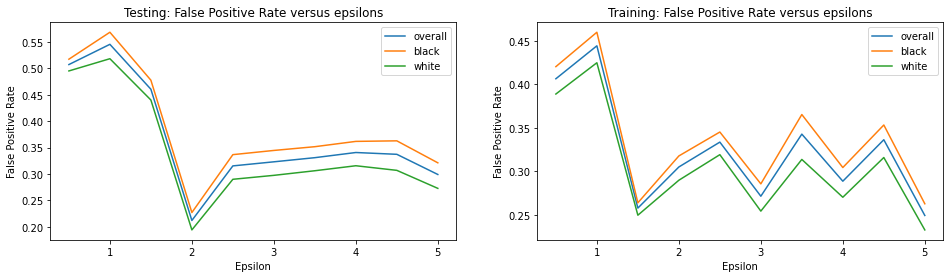

In [43]:
f = plt.figure(figsize=(16,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(epsilons,[result[0][0] for result in test_results],label="overall")
ax.plot(epsilons,[result[1][0] for result in test_results],label="black")
ax.plot(epsilons,[result[2][0] for result in test_results],label="white")
ax.legend()
ax.set_title("Testing: False Positive Rate versus epsilons")
ax.set_ylabel("False Positive Rate")
ax.set_xlabel("Epsilon")

ax2.plot(epsilons,[result[0][0] for result in train_results],label="overall")
ax2.plot(epsilons,[result[1][0] for result in train_results],label="black")
ax2.plot(epsilons,[result[2][0] for result in train_results],label="white")
ax2.legend()
ax2.set_title("Training: False Positive Rate versus epsilons")
ax2.set_ylabel("False Positive Rate")
ax2.set_xlabel("Epsilon")

Text(0.5, 0, 'Epsilon')

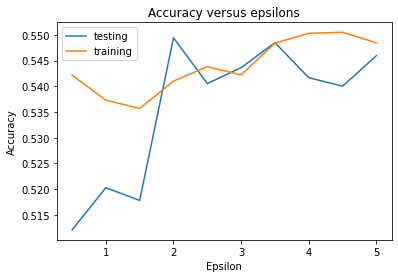

In [25]:
plt.plot(epsilons,[result[0][4] for result in test_results],label="testing")
plt.plot(epsilons,[result[0][4] for result in train_results],label="training")
plt.legend()
plt.title("Accuracy versus epsilons")
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")

Text(0, 0.5, 'Equalized odds distance')

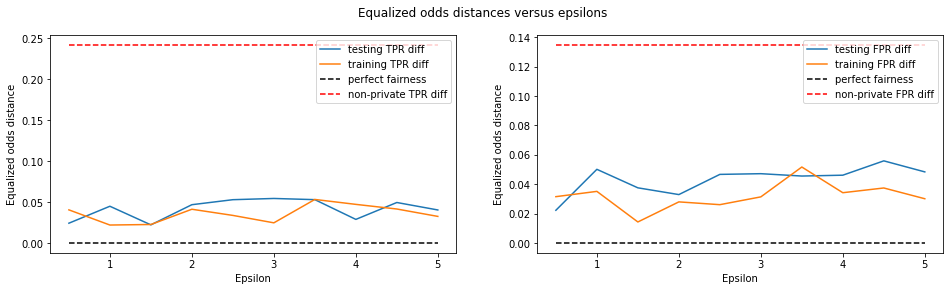

In [26]:
f = plt.figure(figsize=(16,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.suptitle("Equalized odds distances versus epsilons")

# black TPR - white TPR
ax.plot(epsilons,[result[1][2]-result[2][2] for result in test_results],label="testing TPR diff")
ax.plot(epsilons,[result[1][2]-result[2][2] for result in train_results],label="training TPR diff")
ax.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
ax.hlines(0.24133825777,xmin=min(epsilons), xmax=max(epsilons),label="non-private TPR diff",linestyles="--",color="red")
ax.legend()
ax.set_xlabel("Epsilon")
ax.set_ylabel("Equalized odds distance")

# black FPR - white FPR
ax2.plot(epsilons,[result[1][0]-result[2][0] for result in test_results],label="testing FPR diff")
ax2.plot(epsilons,[result[1][0]-result[2][0] for result in train_results],label="training FPR diff")
ax2.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
ax2.hlines(0.13450471332,xmin=min(epsilons), xmax=max(epsilons),label="non-private FPR diff",linestyles="--",color="red")
ax2.legend()
ax2.set_xlabel("Epsilon")
ax2.set_ylabel("Equalized odds distance")